In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from alphamind.api import *
from PyFin.api import *
from PyFin.Math.Accumulators.StatefulAccumulators import MovingAverage
from PyFin.Math.Accumulators.StatefulAccumulators import MovingSharp
from PyFin.Math.Accumulators.StatefulAccumulators import MovingMaxDrawdown

plt.style.use('ggplot')

In [2]:
"""
Back test parameter settings
"""

start_date = '2012-01-01'
end_date = '2018-01-02'
benchmark_code = 300
universe_name = ['zz500', 'hs300']
universe = Universe(universe_name, universe_name)
frequency = '5b'
batch = 8
method = 'risk_neutral'
use_rank = 100
industry_lower = 1.
industry_upper = 1.
neutralize_risk = ['SIZE', 'LEVERAGE'] + industry_styles
constraint_risk = ['SIZE', 'LEVERAGE'] + industry_styles
size_risk_lower = 0
size_risk_upper = 0
turn_over_target_base = 0.25
weight_gaps = [0.02]
benchmark_total_lower = 0.8
benchmark_total_upper = 1.
horizon = map_freq(frequency)
hedging_ratio = 0.

executor = NaiveExecutor()

In [3]:
"""
Model phase: we need 1 constant linear model and one alpha model
"""

const_features_keys = ['roe_q_raw',
                       'ep_q_raw',
                       'DivP_raw',
                       'cfinc1_q_raw',
                       'EBIT_raw',
                       'EARNYILD_raw',
                       'EPIBS_raw']

const_weights = [0.2,
                 0.2,
                 0.1,
                 0.15,
                 0.10,
                 0.10,
                 0.10]

const_weights = pd.Series(const_weights,
                          index=const_features_keys)

const_model = ConstLinearModel(features=const_features_keys,
                               weights=const_weights)

linear_model_features = {
    'ep_q_raw': LAST('ep_q'),
    'roe_q_raw': LAST('roe_q'),
    #'con_np_rolling_raw': LAST('con_np_rolling'),
    'DivP_raw': LAST('DivP'),
    'cfinc1_q_raw': LAST('cfinc1_q'),
    'EBIT_raw': LAST('EBIT'),
    'EARNYILD_raw': LAST('EARNYILD'),
    'EPIBS_raw': LAST('EPIBS')
}

total_features = {
    'IVR_raw': LAST('IVR'),
    'DivP_raw': LAST('DivP'),
    'cfinc1_q_raw': LAST('cfinc1_q'),
    'CFinc1_raw': LAST('CFinc1'),
    'roe_q_raw': LAST('roe_q'),
    'ep_q_raw': LAST('ep_q'),
    'EBIT_raw': LAST('EBIT'),
    'EARNYILD_raw': LAST('EARNYILD'),
    'EPIBS_raw': LAST('EPIBS')
}

total_features_keys = list(total_features.keys())

model1_weight = 1.
model2_weight = 0.5

In [4]:
"""
Data phase
"""

engine = SqlEngine()

linear_model_factor_data = fetch_data_package(engine,
                                              alpha_factors=linear_model_features,
                                              start_date=start_date,
                                              end_date=end_date,
                                              frequency=frequency,
                                              universe=universe,
                                              benchmark=benchmark_code,
                                              batch=batch,
                                              neutralized_risk=neutralize_risk,
                                              pre_process=[winsorize_normal, standardize],
                                              post_process=[winsorize_normal, standardize],
                                              warm_start=batch)

linear_model_features_keys = linear_model_factor_data['x_names']

train_x = linear_model_factor_data['train']['x']
train_y = linear_model_factor_data['train']['y']
ref_dates = sorted(train_x.keys())

predict_x = linear_model_factor_data['predict']['x']
predict_y = linear_model_factor_data['predict']['y']
settlement = linear_model_factor_data['settlement']


2018-01-03 16:34:53,014 - ALPHA_MIND - INFO - Starting data package fetching ...
2018-01-03 16:35:35,374 - ALPHA_MIND - INFO - Loading data is finished
2018-01-03 16:35:38,403 - ALPHA_MIND - INFO - Data processing is finished


In [5]:
"""
Training phase
"""

models_series = pd.Series()

for ref_date in ref_dates:
    x = train_x[ref_date]
    y = train_y[ref_date].flatten()

    model = LassoRegression(alpha=0.01, features=linear_model_features_keys, fit_intercept=True) # n_jobs=8, min_samples_split=20)
    model.fit(x, y)
    models_series.loc[ref_date] = model
    alpha_logger.info('trade_date: {0} training finished'.format(ref_date))


frequency = '5b'
ref_dates = makeSchedule(start_date, end_date, frequency, 'china.sse')

const_model_factor_data = engine.fetch_data_range(universe,
                                                  total_features,
                                                  dates=ref_dates,
                                                  benchmark=benchmark_code)['factor']

horizon = map_freq(frequency)

2018-01-03 16:35:45,678 - ALPHA_MIND - INFO - trade_date: 2012-02-08 00:00:00 training finished
2018-01-03 16:35:45,684 - ALPHA_MIND - INFO - trade_date: 2012-02-15 00:00:00 training finished
2018-01-03 16:35:45,689 - ALPHA_MIND - INFO - trade_date: 2012-02-22 00:00:00 training finished
2018-01-03 16:35:45,694 - ALPHA_MIND - INFO - trade_date: 2012-02-29 00:00:00 training finished
2018-01-03 16:35:45,698 - ALPHA_MIND - INFO - trade_date: 2012-03-07 00:00:00 training finished
2018-01-03 16:35:45,701 - ALPHA_MIND - INFO - trade_date: 2012-03-14 00:00:00 training finished
2018-01-03 16:35:45,706 - ALPHA_MIND - INFO - trade_date: 2012-03-21 00:00:00 training finished
2018-01-03 16:35:45,711 - ALPHA_MIND - INFO - trade_date: 2012-03-28 00:00:00 training finished
2018-01-03 16:35:45,716 - ALPHA_MIND - INFO - trade_date: 2012-04-09 00:00:00 training finished
2018-01-03 16:35:45,722 - ALPHA_MIND - INFO - trade_date: 2012-04-16 00:00:00 training finished
2018-01-03 16:35:45,728 - ALPHA_MIND - I

2018-01-03 16:35:46,050 - ALPHA_MIND - INFO - trade_date: 2013-11-12 00:00:00 training finished
2018-01-03 16:35:46,056 - ALPHA_MIND - INFO - trade_date: 2013-11-19 00:00:00 training finished
2018-01-03 16:35:46,060 - ALPHA_MIND - INFO - trade_date: 2013-11-26 00:00:00 training finished
2018-01-03 16:35:46,063 - ALPHA_MIND - INFO - trade_date: 2013-12-03 00:00:00 training finished
2018-01-03 16:35:46,067 - ALPHA_MIND - INFO - trade_date: 2013-12-10 00:00:00 training finished
2018-01-03 16:35:46,070 - ALPHA_MIND - INFO - trade_date: 2013-12-17 00:00:00 training finished
2018-01-03 16:35:46,074 - ALPHA_MIND - INFO - trade_date: 2013-12-24 00:00:00 training finished
2018-01-03 16:35:46,078 - ALPHA_MIND - INFO - trade_date: 2013-12-31 00:00:00 training finished
2018-01-03 16:35:46,082 - ALPHA_MIND - INFO - trade_date: 2014-01-08 00:00:00 training finished
2018-01-03 16:35:46,086 - ALPHA_MIND - INFO - trade_date: 2014-01-15 00:00:00 training finished
2018-01-03 16:35:46,090 - ALPHA_MIND - I

2018-01-03 16:35:46,419 - ALPHA_MIND - INFO - trade_date: 2015-08-05 00:00:00 training finished
2018-01-03 16:35:46,425 - ALPHA_MIND - INFO - trade_date: 2015-08-12 00:00:00 training finished
2018-01-03 16:35:46,430 - ALPHA_MIND - INFO - trade_date: 2015-08-19 00:00:00 training finished
2018-01-03 16:35:46,436 - ALPHA_MIND - INFO - trade_date: 2015-08-26 00:00:00 training finished
2018-01-03 16:35:46,442 - ALPHA_MIND - INFO - trade_date: 2015-09-02 00:00:00 training finished
2018-01-03 16:35:46,447 - ALPHA_MIND - INFO - trade_date: 2015-09-11 00:00:00 training finished
2018-01-03 16:35:46,452 - ALPHA_MIND - INFO - trade_date: 2015-09-18 00:00:00 training finished
2018-01-03 16:35:46,456 - ALPHA_MIND - INFO - trade_date: 2015-09-25 00:00:00 training finished
2018-01-03 16:35:46,462 - ALPHA_MIND - INFO - trade_date: 2015-10-09 00:00:00 training finished
2018-01-03 16:35:46,467 - ALPHA_MIND - INFO - trade_date: 2015-10-16 00:00:00 training finished
2018-01-03 16:35:46,473 - ALPHA_MIND - I

2018-01-03 16:35:46,854 - ALPHA_MIND - INFO - trade_date: 2017-05-08 00:00:00 training finished
2018-01-03 16:35:46,858 - ALPHA_MIND - INFO - trade_date: 2017-05-15 00:00:00 training finished
2018-01-03 16:35:46,862 - ALPHA_MIND - INFO - trade_date: 2017-05-22 00:00:00 training finished
2018-01-03 16:35:46,868 - ALPHA_MIND - INFO - trade_date: 2017-05-31 00:00:00 training finished
2018-01-03 16:35:46,873 - ALPHA_MIND - INFO - trade_date: 2017-06-07 00:00:00 training finished
2018-01-03 16:35:46,878 - ALPHA_MIND - INFO - trade_date: 2017-06-14 00:00:00 training finished
2018-01-03 16:35:46,884 - ALPHA_MIND - INFO - trade_date: 2017-06-21 00:00:00 training finished
2018-01-03 16:35:46,891 - ALPHA_MIND - INFO - trade_date: 2017-06-28 00:00:00 training finished
2018-01-03 16:35:46,895 - ALPHA_MIND - INFO - trade_date: 2017-07-05 00:00:00 training finished
2018-01-03 16:35:46,899 - ALPHA_MIND - INFO - trade_date: 2017-07-12 00:00:00 training finished
2018-01-03 16:35:46,904 - ALPHA_MIND - I

2018-01-03 16:36:38,180 - ALPHA_MIND - INFO - 2012-01-04 00:00:00: 800
2018-01-03 16:36:38,197 - ALPHA_MIND - INFO - 2012-01-11 00:00:00: 800


start 0.02 weight gap simulation ...


2018-01-03 16:36:38,206 - ALPHA_MIND - INFO - 2012-01-18 00:00:00: 800
2018-01-03 16:36:38,216 - ALPHA_MIND - INFO - 2012-02-01 00:00:00: 800
2018-01-03 16:36:38,225 - ALPHA_MIND - INFO - 2012-02-08 00:00:00: 800
2018-01-03 16:36:38,363 - ALPHA_MIND - INFO - 2012-02-08 00:00:00 is finished
2018-01-03 16:36:38,369 - ALPHA_MIND - INFO - 2012-02-15 00:00:00: 800


using alpha model
using alpha model


2018-01-03 16:36:38,607 - ALPHA_MIND - INFO - 2012-02-15 00:00:00 is finished
2018-01-03 16:36:38,613 - ALPHA_MIND - INFO - 2012-02-22 00:00:00: 800
2018-01-03 16:36:38,822 - ALPHA_MIND - INFO - 2012-02-22 00:00:00 is finished


using alpha model


2018-01-03 16:36:38,829 - ALPHA_MIND - INFO - 2012-02-29 00:00:00: 800


using alpha model


2018-01-03 16:36:39,059 - ALPHA_MIND - INFO - 2012-02-29 00:00:00 is finished
2018-01-03 16:36:39,065 - ALPHA_MIND - INFO - 2012-03-07 00:00:00: 799


using alpha model


2018-01-03 16:36:39,274 - ALPHA_MIND - INFO - 2012-03-07 00:00:00 is finished
2018-01-03 16:36:39,281 - ALPHA_MIND - INFO - 2012-03-14 00:00:00: 799
2018-01-03 16:36:39,490 - ALPHA_MIND - INFO - 2012-03-14 00:00:00 is finished

using alpha model



2018-01-03 16:36:39,497 - ALPHA_MIND - INFO - 2012-03-21 00:00:00: 798


using alpha model


2018-01-03 16:36:39,716 - ALPHA_MIND - INFO - 2012-03-21 00:00:00 is finished
2018-01-03 16:36:39,722 - ALPHA_MIND - INFO - 2012-03-28 00:00:00: 798


using alpha model


2018-01-03 16:36:39,980 - ALPHA_MIND - INFO - 2012-03-28 00:00:00 is finished
2018-01-03 16:36:39,985 - ALPHA_MIND - INFO - 2012-04-09 00:00:00: 800


using alpha model


2018-01-03 16:36:40,226 - ALPHA_MIND - INFO - 2012-04-09 00:00:00 is finished
2018-01-03 16:36:40,231 - ALPHA_MIND - INFO - 2012-04-16 00:00:00: 800


using alpha model


2018-01-03 16:36:40,464 - ALPHA_MIND - INFO - 2012-04-16 00:00:00 is finished
2018-01-03 16:36:40,469 - ALPHA_MIND - INFO - 2012-04-23 00:00:00: 800


using alpha model


2018-01-03 16:36:40,722 - ALPHA_MIND - INFO - 2012-04-23 00:00:00 is finished
2018-01-03 16:36:40,727 - ALPHA_MIND - INFO - 2012-05-02 00:00:00: 800


using alpha model


2018-01-03 16:36:40,949 - ALPHA_MIND - INFO - 2012-05-02 00:00:00 is finished
2018-01-03 16:36:40,954 - ALPHA_MIND - INFO - 2012-05-09 00:00:00: 800
2018-01-03 16:36:41,164 - ALPHA_MIND - INFO - 2012-05-09 00:00:00 is finished


using alpha model


2018-01-03 16:36:41,172 - ALPHA_MIND - INFO - 2012-05-16 00:00:00: 800


using alpha model


2018-01-03 16:36:41,409 - ALPHA_MIND - INFO - 2012-05-16 00:00:00 is finished
2018-01-03 16:36:41,415 - ALPHA_MIND - INFO - 2012-05-23 00:00:00: 800
2018-01-03 16:36:41,623 - ALPHA_MIND - INFO - 2012-05-23 00:00:00 is finished


using alpha model


2018-01-03 16:36:41,629 - ALPHA_MIND - INFO - 2012-05-30 00:00:00: 800


using alpha model


2018-01-03 16:36:41,876 - ALPHA_MIND - INFO - 2012-05-30 00:00:00 is finished
2018-01-03 16:36:41,883 - ALPHA_MIND - INFO - 2012-06-06 00:00:00: 800


using alpha model


2018-01-03 16:36:42,132 - ALPHA_MIND - INFO - 2012-06-06 00:00:00 is finished
2018-01-03 16:36:42,137 - ALPHA_MIND - INFO - 2012-06-13 00:00:00: 800


using alpha model


2018-01-03 16:36:42,365 - ALPHA_MIND - INFO - 2012-06-13 00:00:00 is finished
2018-01-03 16:36:42,371 - ALPHA_MIND - INFO - 2012-06-20 00:00:00: 800


using alpha model


2018-01-03 16:36:42,582 - ALPHA_MIND - INFO - 2012-06-20 00:00:00 is finished
2018-01-03 16:36:42,588 - ALPHA_MIND - INFO - 2012-06-28 00:00:00: 800


using alpha model


2018-01-03 16:36:42,807 - ALPHA_MIND - INFO - 2012-06-28 00:00:00 is finished
2018-01-03 16:36:42,812 - ALPHA_MIND - INFO - 2012-07-05 00:00:00: 800


using alpha model


2018-01-03 16:36:43,040 - ALPHA_MIND - INFO - 2012-07-05 00:00:00 is finished
2018-01-03 16:36:43,047 - ALPHA_MIND - INFO - 2012-07-12 00:00:00: 800


using alpha model


2018-01-03 16:36:43,301 - ALPHA_MIND - INFO - 2012-07-12 00:00:00 is finished
2018-01-03 16:36:43,306 - ALPHA_MIND - INFO - 2012-07-19 00:00:00: 800


using alpha model


2018-01-03 16:36:43,544 - ALPHA_MIND - INFO - 2012-07-19 00:00:00 is finished
2018-01-03 16:36:43,549 - ALPHA_MIND - INFO - 2012-07-26 00:00:00: 800


using alpha model


2018-01-03 16:36:43,770 - ALPHA_MIND - INFO - 2012-07-26 00:00:00 is finished
2018-01-03 16:36:43,776 - ALPHA_MIND - INFO - 2012-08-02 00:00:00: 800


using alpha model


2018-01-03 16:36:44,012 - ALPHA_MIND - INFO - 2012-08-02 00:00:00 is finished
2018-01-03 16:36:44,020 - ALPHA_MIND - INFO - 2012-08-09 00:00:00: 800


using alpha model


2018-01-03 16:36:44,248 - ALPHA_MIND - INFO - 2012-08-09 00:00:00 is finished
2018-01-03 16:36:44,255 - ALPHA_MIND - INFO - 2012-08-16 00:00:00: 800


using alpha model


2018-01-03 16:36:44,499 - ALPHA_MIND - INFO - 2012-08-16 00:00:00 is finished
2018-01-03 16:36:44,505 - ALPHA_MIND - INFO - 2012-08-23 00:00:00: 800


using alpha model


2018-01-03 16:36:44,729 - ALPHA_MIND - INFO - 2012-08-23 00:00:00 is finished
2018-01-03 16:36:44,734 - ALPHA_MIND - INFO - 2012-08-30 00:00:00: 800


using alpha model


2018-01-03 16:36:44,946 - ALPHA_MIND - INFO - 2012-08-30 00:00:00 is finished
2018-01-03 16:36:44,952 - ALPHA_MIND - INFO - 2012-09-06 00:00:00: 800


using alpha model


2018-01-03 16:36:45,185 - ALPHA_MIND - INFO - 2012-09-06 00:00:00 is finished
2018-01-03 16:36:45,190 - ALPHA_MIND - INFO - 2012-09-13 00:00:00: 800


using alpha model


2018-01-03 16:36:45,410 - ALPHA_MIND - INFO - 2012-09-13 00:00:00 is finished
2018-01-03 16:36:45,417 - ALPHA_MIND - INFO - 2012-09-20 00:00:00: 800


using alpha model


2018-01-03 16:36:45,662 - ALPHA_MIND - INFO - 2012-09-20 00:00:00 is finished
2018-01-03 16:36:45,667 - ALPHA_MIND - INFO - 2012-09-27 00:00:00: 800


using alpha model


2018-01-03 16:36:45,885 - ALPHA_MIND - INFO - 2012-09-27 00:00:00 is finished
2018-01-03 16:36:45,892 - ALPHA_MIND - INFO - 2012-10-11 00:00:00: 800


using alpha model


2018-01-03 16:36:46,130 - ALPHA_MIND - INFO - 2012-10-11 00:00:00 is finished
2018-01-03 16:36:46,137 - ALPHA_MIND - INFO - 2012-10-18 00:00:00: 800


using alpha model


2018-01-03 16:36:46,485 - ALPHA_MIND - INFO - 2012-10-18 00:00:00 is finished
2018-01-03 16:36:46,490 - ALPHA_MIND - INFO - 2012-10-25 00:00:00: 800


using alpha model


2018-01-03 16:36:46,752 - ALPHA_MIND - INFO - 2012-10-25 00:00:00 is finished
2018-01-03 16:36:46,757 - ALPHA_MIND - INFO - 2012-11-01 00:00:00: 800


using alpha model


2018-01-03 16:36:46,972 - ALPHA_MIND - INFO - 2012-11-01 00:00:00 is finished
2018-01-03 16:36:46,980 - ALPHA_MIND - INFO - 2012-11-08 00:00:00: 800


using alpha model


2018-01-03 16:36:47,207 - ALPHA_MIND - INFO - 2012-11-08 00:00:00 is finished
2018-01-03 16:36:47,214 - ALPHA_MIND - INFO - 2012-11-15 00:00:00: 800


using alpha model


2018-01-03 16:36:47,426 - ALPHA_MIND - INFO - 2012-11-15 00:00:00 is finished
2018-01-03 16:36:47,432 - ALPHA_MIND - INFO - 2012-11-22 00:00:00: 800
2018-01-03 16:36:47,642 - ALPHA_MIND - INFO - 2012-11-22 00:00:00 is finished


using alpha model


2018-01-03 16:36:47,647 - ALPHA_MIND - INFO - 2012-11-29 00:00:00: 800


using alpha model


2018-01-03 16:36:47,863 - ALPHA_MIND - INFO - 2012-11-29 00:00:00 is finished
2018-01-03 16:36:47,869 - ALPHA_MIND - INFO - 2012-12-06 00:00:00: 800


using alpha model


2018-01-03 16:36:48,087 - ALPHA_MIND - INFO - 2012-12-06 00:00:00 is finished
2018-01-03 16:36:48,093 - ALPHA_MIND - INFO - 2012-12-13 00:00:00: 800


using alpha model


2018-01-03 16:36:48,311 - ALPHA_MIND - INFO - 2012-12-13 00:00:00 is finished
2018-01-03 16:36:48,318 - ALPHA_MIND - INFO - 2012-12-20 00:00:00: 800


using alpha model


2018-01-03 16:36:48,553 - ALPHA_MIND - INFO - 2012-12-20 00:00:00 is finished
2018-01-03 16:36:48,558 - ALPHA_MIND - INFO - 2012-12-27 00:00:00: 800


using alpha model


2018-01-03 16:36:48,789 - ALPHA_MIND - INFO - 2012-12-27 00:00:00 is finished
2018-01-03 16:36:48,795 - ALPHA_MIND - INFO - 2013-01-08 00:00:00: 800


using alpha model


2018-01-03 16:36:49,014 - ALPHA_MIND - INFO - 2013-01-08 00:00:00 is finished
2018-01-03 16:36:49,021 - ALPHA_MIND - INFO - 2013-01-15 00:00:00: 800


using alpha model


2018-01-03 16:36:49,260 - ALPHA_MIND - INFO - 2013-01-15 00:00:00 is finished
2018-01-03 16:36:49,269 - ALPHA_MIND - INFO - 2013-01-22 00:00:00: 800


using alpha model


2018-01-03 16:36:49,513 - ALPHA_MIND - INFO - 2013-01-22 00:00:00 is finished
2018-01-03 16:36:49,518 - ALPHA_MIND - INFO - 2013-01-29 00:00:00: 800


using alpha model


2018-01-03 16:36:49,735 - ALPHA_MIND - INFO - 2013-01-29 00:00:00 is finished
2018-01-03 16:36:49,740 - ALPHA_MIND - INFO - 2013-02-05 00:00:00: 800


using alpha model


2018-01-03 16:36:49,968 - ALPHA_MIND - INFO - 2013-02-05 00:00:00 is finished
2018-01-03 16:36:49,974 - ALPHA_MIND - INFO - 2013-02-19 00:00:00: 800


using alpha model


2018-01-03 16:36:50,292 - ALPHA_MIND - INFO - 2013-02-19 00:00:00 is finished
2018-01-03 16:36:50,297 - ALPHA_MIND - INFO - 2013-02-26 00:00:00: 800


using alpha model


2018-01-03 16:36:50,519 - ALPHA_MIND - INFO - 2013-02-26 00:00:00 is finished
2018-01-03 16:36:50,525 - ALPHA_MIND - INFO - 2013-03-05 00:00:00: 800


using alpha model


2018-01-03 16:36:50,754 - ALPHA_MIND - INFO - 2013-03-05 00:00:00 is finished
2018-01-03 16:36:50,761 - ALPHA_MIND - INFO - 2013-03-12 00:00:00: 800


using alpha model


2018-01-03 16:36:50,990 - ALPHA_MIND - INFO - 2013-03-12 00:00:00 is finished
2018-01-03 16:36:50,996 - ALPHA_MIND - INFO - 2013-03-19 00:00:00: 800


using alpha model


2018-01-03 16:36:51,227 - ALPHA_MIND - INFO - 2013-03-19 00:00:00 is finished
2018-01-03 16:36:51,232 - ALPHA_MIND - INFO - 2013-03-26 00:00:00: 800


using alpha model


2018-01-03 16:36:51,474 - ALPHA_MIND - INFO - 2013-03-26 00:00:00 is finished
2018-01-03 16:36:51,480 - ALPHA_MIND - INFO - 2013-04-02 00:00:00: 800


using alpha model


2018-01-03 16:36:51,695 - ALPHA_MIND - INFO - 2013-04-02 00:00:00 is finished
2018-01-03 16:36:51,701 - ALPHA_MIND - INFO - 2013-04-11 00:00:00: 800


using alpha model


2018-01-03 16:36:51,934 - ALPHA_MIND - INFO - 2013-04-11 00:00:00 is finished
2018-01-03 16:36:51,939 - ALPHA_MIND - INFO - 2013-04-18 00:00:00: 800


using alpha model


2018-01-03 16:36:52,159 - ALPHA_MIND - INFO - 2013-04-18 00:00:00 is finished
2018-01-03 16:36:52,165 - ALPHA_MIND - INFO - 2013-04-25 00:00:00: 800


using alpha model


2018-01-03 16:36:52,389 - ALPHA_MIND - INFO - 2013-04-25 00:00:00 is finished
2018-01-03 16:36:52,395 - ALPHA_MIND - INFO - 2013-05-07 00:00:00: 800


using alpha model


2018-01-03 16:36:52,622 - ALPHA_MIND - INFO - 2013-05-07 00:00:00 is finished
2018-01-03 16:36:52,628 - ALPHA_MIND - INFO - 2013-05-14 00:00:00: 800
2018-01-03 16:36:52,835 - ALPHA_MIND - INFO - 2013-05-14 00:00:00 is finished


using alpha model


2018-01-03 16:36:52,839 - ALPHA_MIND - INFO - 2013-05-21 00:00:00: 800


using alpha model


2018-01-03 16:36:53,055 - ALPHA_MIND - INFO - 2013-05-21 00:00:00 is finished
2018-01-03 16:36:53,060 - ALPHA_MIND - INFO - 2013-05-28 00:00:00: 800


using alpha model


2018-01-03 16:36:53,280 - ALPHA_MIND - INFO - 2013-05-28 00:00:00 is finished
2018-01-03 16:36:53,285 - ALPHA_MIND - INFO - 2013-06-04 00:00:00: 800


using alpha model


2018-01-03 16:36:53,495 - ALPHA_MIND - INFO - 2013-06-04 00:00:00 is finished
2018-01-03 16:36:53,502 - ALPHA_MIND - INFO - 2013-06-14 00:00:00: 800


using alpha model


2018-01-03 16:36:53,722 - ALPHA_MIND - INFO - 2013-06-14 00:00:00 is finished
2018-01-03 16:36:53,728 - ALPHA_MIND - INFO - 2013-06-21 00:00:00: 800


using alpha model


2018-01-03 16:36:54,029 - ALPHA_MIND - INFO - 2013-06-21 00:00:00 is finished
2018-01-03 16:36:54,035 - ALPHA_MIND - INFO - 2013-06-28 00:00:00: 800
2018-01-03 16:36:54,243 - ALPHA_MIND - INFO - 2013-06-28 00:00:00 is finished


using alpha model


2018-01-03 16:36:54,247 - ALPHA_MIND - INFO - 2013-07-05 00:00:00: 800
2018-01-03 16:36:54,456 - ALPHA_MIND - INFO - 2013-07-05 00:00:00 is finished


using alpha model


2018-01-03 16:36:54,463 - ALPHA_MIND - INFO - 2013-07-12 00:00:00: 800


using alpha model


2018-01-03 16:36:54,684 - ALPHA_MIND - INFO - 2013-07-12 00:00:00 is finished
2018-01-03 16:36:54,691 - ALPHA_MIND - INFO - 2013-07-19 00:00:00: 800


using alpha model


2018-01-03 16:36:54,915 - ALPHA_MIND - INFO - 2013-07-19 00:00:00 is finished
2018-01-03 16:36:54,921 - ALPHA_MIND - INFO - 2013-07-26 00:00:00: 800


using alpha model


2018-01-03 16:36:55,136 - ALPHA_MIND - INFO - 2013-07-26 00:00:00 is finished
2018-01-03 16:36:55,142 - ALPHA_MIND - INFO - 2013-08-02 00:00:00: 800
2018-01-03 16:36:55,343 - ALPHA_MIND - INFO - 2013-08-02 00:00:00 is finished
2018-01-03 16:36:55,348 - ALPHA_MIND - INFO - 2013-08-09 00:00:00: 800


using alpha model
using alpha model

2018-01-03 16:36:55,559 - ALPHA_MIND - INFO - 2013-08-09 00:00:00 is finished
2018-01-03 16:36:55,563 - ALPHA_MIND - INFO - 2013-08-16 00:00:00: 800



using alpha model


2018-01-03 16:36:55,777 - ALPHA_MIND - INFO - 2013-08-16 00:00:00 is finished
2018-01-03 16:36:55,784 - ALPHA_MIND - INFO - 2013-08-23 00:00:00: 800


using alpha model


2018-01-03 16:36:56,027 - ALPHA_MIND - INFO - 2013-08-23 00:00:00 is finished
2018-01-03 16:36:56,034 - ALPHA_MIND - INFO - 2013-08-30 00:00:00: 800
2018-01-03 16:36:56,243 - ALPHA_MIND - INFO - 2013-08-30 00:00:00 is finished


using alpha model


2018-01-03 16:36:56,248 - ALPHA_MIND - INFO - 2013-09-06 00:00:00: 800
2018-01-03 16:36:56,459 - ALPHA_MIND - INFO - 2013-09-06 00:00:00 is finished


using alpha model


2018-01-03 16:36:56,465 - ALPHA_MIND - INFO - 2013-09-13 00:00:00: 800
2018-01-03 16:36:56,667 - ALPHA_MIND - INFO - 2013-09-13 00:00:00 is finished
2018-01-03 16:36:56,672 - ALPHA_MIND - INFO - 2013-09-24 00:00:00: 799


using alpha model


2018-01-03 16:36:56,879 - ALPHA_MIND - INFO - 2013-09-24 00:00:00 is finished


using alpha model


2018-01-03 16:36:56,885 - ALPHA_MIND - INFO - 2013-10-08 00:00:00: 800


using alpha model


2018-01-03 16:36:57,124 - ALPHA_MIND - INFO - 2013-10-08 00:00:00 is finished
2018-01-03 16:36:57,129 - ALPHA_MIND - INFO - 2013-10-15 00:00:00: 800


using alpha model


2018-01-03 16:36:57,351 - ALPHA_MIND - INFO - 2013-10-15 00:00:00 is finished
2018-01-03 16:36:57,356 - ALPHA_MIND - INFO - 2013-10-22 00:00:00: 800


using alpha model


2018-01-03 16:36:57,643 - ALPHA_MIND - INFO - 2013-10-22 00:00:00 is finished
2018-01-03 16:36:57,649 - ALPHA_MIND - INFO - 2013-10-29 00:00:00: 800
2018-01-03 16:36:57,853 - ALPHA_MIND - INFO - 2013-10-29 00:00:00 is finished
2018-01-03 16:36:57,859 - ALPHA_MIND - INFO - 2013-11-05 00:00:00: 800


using alpha model
using alpha model


2018-01-03 16:36:58,076 - ALPHA_MIND - INFO - 2013-11-05 00:00:00 is finished
2018-01-03 16:36:58,083 - ALPHA_MIND - INFO - 2013-11-12 00:00:00: 800


using alpha model


2018-01-03 16:36:58,305 - ALPHA_MIND - INFO - 2013-11-12 00:00:00 is finished
2018-01-03 16:36:58,312 - ALPHA_MIND - INFO - 2013-11-19 00:00:00: 800


using alpha model


2018-01-03 16:36:58,524 - ALPHA_MIND - INFO - 2013-11-19 00:00:00 is finished
2018-01-03 16:36:58,530 - ALPHA_MIND - INFO - 2013-11-26 00:00:00: 800
2018-01-03 16:36:58,735 - ALPHA_MIND - INFO - 2013-11-26 00:00:00 is finished


using alpha model


2018-01-03 16:36:58,741 - ALPHA_MIND - INFO - 2013-12-03 00:00:00: 800


using alpha model


2018-01-03 16:36:58,968 - ALPHA_MIND - INFO - 2013-12-03 00:00:00 is finished
2018-01-03 16:36:58,974 - ALPHA_MIND - INFO - 2013-12-10 00:00:00: 800


using alpha model


2018-01-03 16:36:59,193 - ALPHA_MIND - INFO - 2013-12-10 00:00:00 is finished
2018-01-03 16:36:59,199 - ALPHA_MIND - INFO - 2013-12-17 00:00:00: 800


using alpha model


2018-01-03 16:36:59,420 - ALPHA_MIND - INFO - 2013-12-17 00:00:00 is finished
2018-01-03 16:36:59,425 - ALPHA_MIND - INFO - 2013-12-24 00:00:00: 800
2018-01-03 16:36:59,631 - ALPHA_MIND - INFO - 2013-12-24 00:00:00 is finished


using alpha model


2018-01-03 16:36:59,638 - ALPHA_MIND - INFO - 2013-12-31 00:00:00: 800
2018-01-03 16:36:59,844 - ALPHA_MIND - INFO - 2013-12-31 00:00:00 is finished
2018-01-03 16:36:59,849 - ALPHA_MIND - INFO - 2014-01-08 00:00:00: 800


using alpha model
using alpha model


2018-01-03 16:37:00,076 - ALPHA_MIND - INFO - 2014-01-08 00:00:00 is finished
2018-01-03 16:37:00,081 - ALPHA_MIND - INFO - 2014-01-15 00:00:00: 800


using alpha model


2018-01-03 16:37:00,321 - ALPHA_MIND - INFO - 2014-01-15 00:00:00 is finished
2018-01-03 16:37:00,328 - ALPHA_MIND - INFO - 2014-01-22 00:00:00: 800


using alpha model


2018-01-03 16:37:00,552 - ALPHA_MIND - INFO - 2014-01-22 00:00:00 is finished
2018-01-03 16:37:00,558 - ALPHA_MIND - INFO - 2014-01-29 00:00:00: 800
2018-01-03 16:37:00,763 - ALPHA_MIND - INFO - 2014-01-29 00:00:00 is finished


using alpha model


2018-01-03 16:37:00,768 - ALPHA_MIND - INFO - 2014-02-12 00:00:00: 800


using alpha model


2018-01-03 16:37:00,979 - ALPHA_MIND - INFO - 2014-02-12 00:00:00 is finished
2018-01-03 16:37:00,985 - ALPHA_MIND - INFO - 2014-02-19 00:00:00: 800


using alpha model


2018-01-03 16:37:01,277 - ALPHA_MIND - INFO - 2014-02-19 00:00:00 is finished
2018-01-03 16:37:01,282 - ALPHA_MIND - INFO - 2014-02-26 00:00:00: 800


using alpha model


2018-01-03 16:37:01,502 - ALPHA_MIND - INFO - 2014-02-26 00:00:00 is finished
2018-01-03 16:37:01,508 - ALPHA_MIND - INFO - 2014-03-05 00:00:00: 800


using alpha model


2018-01-03 16:37:01,721 - ALPHA_MIND - INFO - 2014-03-05 00:00:00 is finished
2018-01-03 16:37:01,727 - ALPHA_MIND - INFO - 2014-03-12 00:00:00: 800
2018-01-03 16:37:01,929 - ALPHA_MIND - INFO - 2014-03-12 00:00:00 is finished
2018-01-03 16:37:01,935 - ALPHA_MIND - INFO - 2014-03-19 00:00:00: 800


using alpha model
using alpha model


2018-01-03 16:37:02,151 - ALPHA_MIND - INFO - 2014-03-19 00:00:00 is finished
2018-01-03 16:37:02,156 - ALPHA_MIND - INFO - 2014-03-26 00:00:00: 800


using alpha model


2018-01-03 16:37:02,388 - ALPHA_MIND - INFO - 2014-03-26 00:00:00 is finished
2018-01-03 16:37:02,393 - ALPHA_MIND - INFO - 2014-04-02 00:00:00: 800


using alpha model


2018-01-03 16:37:02,611 - ALPHA_MIND - INFO - 2014-04-02 00:00:00 is finished
2018-01-03 16:37:02,617 - ALPHA_MIND - INFO - 2014-04-10 00:00:00: 800


using alpha model


2018-01-03 16:37:02,834 - ALPHA_MIND - INFO - 2014-04-10 00:00:00 is finished
2018-01-03 16:37:02,839 - ALPHA_MIND - INFO - 2014-04-17 00:00:00: 800


using alpha model


2018-01-03 16:37:03,055 - ALPHA_MIND - INFO - 2014-04-17 00:00:00 is finished
2018-01-03 16:37:03,060 - ALPHA_MIND - INFO - 2014-04-24 00:00:00: 800
2018-01-03 16:37:03,267 - ALPHA_MIND - INFO - 2014-04-24 00:00:00 is finished


using alpha model


2018-01-03 16:37:03,274 - ALPHA_MIND - INFO - 2014-05-05 00:00:00: 800


using alpha model


2018-01-03 16:37:03,501 - ALPHA_MIND - INFO - 2014-05-05 00:00:00 is finished
2018-01-03 16:37:03,507 - ALPHA_MIND - INFO - 2014-05-12 00:00:00: 800


using alpha model


2018-01-03 16:37:03,720 - ALPHA_MIND - INFO - 2014-05-12 00:00:00 is finished
2018-01-03 16:37:03,726 - ALPHA_MIND - INFO - 2014-05-19 00:00:00: 800
2018-01-03 16:37:03,933 - ALPHA_MIND - INFO - 2014-05-19 00:00:00 is finished


using alpha model


2018-01-03 16:37:03,939 - ALPHA_MIND - INFO - 2014-05-26 00:00:00: 800


using alpha model


2018-01-03 16:37:04,153 - ALPHA_MIND - INFO - 2014-05-26 00:00:00 is finished
2018-01-03 16:37:04,158 - ALPHA_MIND - INFO - 2014-06-03 00:00:00: 800
2018-01-03 16:37:04,359 - ALPHA_MIND - INFO - 2014-06-03 00:00:00 is finished
2018-01-03 16:37:04,366 - ALPHA_MIND - INFO - 2014-06-10 00:00:00: 800


using alpha model
using alpha model

2018-01-03 16:37:04,591 - ALPHA_MIND - INFO - 2014-06-10 00:00:00 is finished
2018-01-03 16:37:04,596 - ALPHA_MIND - INFO - 2014-06-17 00:00:00: 800



using alpha model


2018-01-03 16:37:04,893 - ALPHA_MIND - INFO - 2014-06-17 00:00:00 is finished
2018-01-03 16:37:04,899 - ALPHA_MIND - INFO - 2014-06-24 00:00:00: 800


using alpha model


2018-01-03 16:37:05,111 - ALPHA_MIND - INFO - 2014-06-24 00:00:00 is finished
2018-01-03 16:37:05,117 - ALPHA_MIND - INFO - 2014-07-01 00:00:00: 800


using alpha model


2018-01-03 16:37:05,330 - ALPHA_MIND - INFO - 2014-07-01 00:00:00 is finished
2018-01-03 16:37:05,336 - ALPHA_MIND - INFO - 2014-07-08 00:00:00: 800


using alpha model


2018-01-03 16:37:05,549 - ALPHA_MIND - INFO - 2014-07-08 00:00:00 is finished
2018-01-03 16:37:05,557 - ALPHA_MIND - INFO - 2014-07-15 00:00:00: 800


using alpha model


2018-01-03 16:37:05,783 - ALPHA_MIND - INFO - 2014-07-15 00:00:00 is finished
2018-01-03 16:37:05,790 - ALPHA_MIND - INFO - 2014-07-22 00:00:00: 800


using alpha model


2018-01-03 16:37:06,020 - ALPHA_MIND - INFO - 2014-07-22 00:00:00 is finished
2018-01-03 16:37:06,026 - ALPHA_MIND - INFO - 2014-07-29 00:00:00: 800
2018-01-03 16:37:06,235 - ALPHA_MIND - INFO - 2014-07-29 00:00:00 is finished


using alpha model


2018-01-03 16:37:06,241 - ALPHA_MIND - INFO - 2014-08-05 00:00:00: 800


using alpha model


2018-01-03 16:37:06,455 - ALPHA_MIND - INFO - 2014-08-05 00:00:00 is finished
2018-01-03 16:37:06,461 - ALPHA_MIND - INFO - 2014-08-12 00:00:00: 800


using alpha model


2018-01-03 16:37:06,684 - ALPHA_MIND - INFO - 2014-08-12 00:00:00 is finished
2018-01-03 16:37:06,690 - ALPHA_MIND - INFO - 2014-08-19 00:00:00: 800


using alpha model


2018-01-03 16:37:06,905 - ALPHA_MIND - INFO - 2014-08-19 00:00:00 is finished
2018-01-03 16:37:06,910 - ALPHA_MIND - INFO - 2014-08-26 00:00:00: 800


using alpha model


2018-01-03 16:37:07,128 - ALPHA_MIND - INFO - 2014-08-26 00:00:00 is finished
2018-01-03 16:37:07,133 - ALPHA_MIND - INFO - 2014-09-02 00:00:00: 800


using alpha model


2018-01-03 16:37:07,346 - ALPHA_MIND - INFO - 2014-09-02 00:00:00 is finished
2018-01-03 16:37:07,351 - ALPHA_MIND - INFO - 2014-09-10 00:00:00: 800


using alpha model


2018-01-03 16:37:07,572 - ALPHA_MIND - INFO - 2014-09-10 00:00:00 is finished
2018-01-03 16:37:07,578 - ALPHA_MIND - INFO - 2014-09-17 00:00:00: 800


using alpha model


2018-01-03 16:37:07,805 - ALPHA_MIND - INFO - 2014-09-17 00:00:00 is finished
2018-01-03 16:37:07,811 - ALPHA_MIND - INFO - 2014-09-24 00:00:00: 800


using alpha model


2018-01-03 16:37:08,026 - ALPHA_MIND - INFO - 2014-09-24 00:00:00 is finished
2018-01-03 16:37:08,032 - ALPHA_MIND - INFO - 2014-10-08 00:00:00: 800


using alpha model


2018-01-03 16:37:08,254 - ALPHA_MIND - INFO - 2014-10-08 00:00:00 is finished
2018-01-03 16:37:08,260 - ALPHA_MIND - INFO - 2014-10-15 00:00:00: 800


using alpha model


2018-01-03 16:37:08,543 - ALPHA_MIND - INFO - 2014-10-15 00:00:00 is finished
2018-01-03 16:37:08,547 - ALPHA_MIND - INFO - 2014-10-22 00:00:00: 800


using alpha model


2018-01-03 16:37:08,777 - ALPHA_MIND - INFO - 2014-10-22 00:00:00 is finished
2018-01-03 16:37:08,785 - ALPHA_MIND - INFO - 2014-10-29 00:00:00: 800


using alpha model


2018-01-03 16:37:09,008 - ALPHA_MIND - INFO - 2014-10-29 00:00:00 is finished
2018-01-03 16:37:09,015 - ALPHA_MIND - INFO - 2014-11-05 00:00:00: 800


using alpha model


2018-01-03 16:37:09,232 - ALPHA_MIND - INFO - 2014-11-05 00:00:00 is finished
2018-01-03 16:37:09,238 - ALPHA_MIND - INFO - 2014-11-12 00:00:00: 800
2018-01-03 16:37:09,447 - ALPHA_MIND - INFO - 2014-11-12 00:00:00 is finished


using alpha model


2018-01-03 16:37:09,452 - ALPHA_MIND - INFO - 2014-11-19 00:00:00: 800


using alpha model


2018-01-03 16:37:09,664 - ALPHA_MIND - INFO - 2014-11-19 00:00:00 is finished
2018-01-03 16:37:09,670 - ALPHA_MIND - INFO - 2014-11-26 00:00:00: 800


using alpha model


2018-01-03 16:37:09,883 - ALPHA_MIND - INFO - 2014-11-26 00:00:00 is finished
2018-01-03 16:37:09,889 - ALPHA_MIND - INFO - 2014-12-03 00:00:00: 800


using alpha model


2018-01-03 16:37:10,125 - ALPHA_MIND - INFO - 2014-12-03 00:00:00 is finished
2018-01-03 16:37:10,129 - ALPHA_MIND - INFO - 2014-12-10 00:00:00: 800


using alpha model


2018-01-03 16:37:10,359 - ALPHA_MIND - INFO - 2014-12-10 00:00:00 is finished
2018-01-03 16:37:10,364 - ALPHA_MIND - INFO - 2014-12-17 00:00:00: 800


using alpha model


2018-01-03 16:37:10,590 - ALPHA_MIND - INFO - 2014-12-17 00:00:00 is finished
2018-01-03 16:37:10,596 - ALPHA_MIND - INFO - 2014-12-24 00:00:00: 800


using alpha model


2018-01-03 16:37:10,807 - ALPHA_MIND - INFO - 2014-12-24 00:00:00 is finished
2018-01-03 16:37:10,813 - ALPHA_MIND - INFO - 2014-12-31 00:00:00: 800


using alpha model


2018-01-03 16:37:11,042 - ALPHA_MIND - INFO - 2014-12-31 00:00:00 is finished
2018-01-03 16:37:11,048 - ALPHA_MIND - INFO - 2015-01-09 00:00:00: 800


using alpha model


2018-01-03 16:37:11,272 - ALPHA_MIND - INFO - 2015-01-09 00:00:00 is finished
2018-01-03 16:37:11,278 - ALPHA_MIND - INFO - 2015-01-16 00:00:00: 800
2018-01-03 16:37:11,481 - ALPHA_MIND - INFO - 2015-01-16 00:00:00 is finished


using alpha model


2018-01-03 16:37:11,487 - ALPHA_MIND - INFO - 2015-01-23 00:00:00: 800
2018-01-03 16:37:11,697 - ALPHA_MIND - INFO - 2015-01-23 00:00:00 is finished


using alpha model


2018-01-03 16:37:11,702 - ALPHA_MIND - INFO - 2015-01-30 00:00:00: 800


using alpha model


2018-01-03 16:37:11,923 - ALPHA_MIND - INFO - 2015-01-30 00:00:00 is finished
2018-01-03 16:37:11,929 - ALPHA_MIND - INFO - 2015-02-06 00:00:00: 800


using alpha model


2018-01-03 16:37:12,235 - ALPHA_MIND - INFO - 2015-02-06 00:00:00 is finished
2018-01-03 16:37:12,241 - ALPHA_MIND - INFO - 2015-02-13 00:00:00: 800
2018-01-03 16:37:12,444 - ALPHA_MIND - INFO - 2015-02-13 00:00:00 is finished
2018-01-03 16:37:12,449 - ALPHA_MIND - INFO - 2015-02-27 00:00:00: 800


using alpha model
using alpha model


2018-01-03 16:37:12,661 - ALPHA_MIND - INFO - 2015-02-27 00:00:00 is finished
2018-01-03 16:37:12,667 - ALPHA_MIND - INFO - 2015-03-06 00:00:00: 800


using alpha model


2018-01-03 16:37:12,878 - ALPHA_MIND - INFO - 2015-03-06 00:00:00 is finished
2018-01-03 16:37:12,884 - ALPHA_MIND - INFO - 2015-03-13 00:00:00: 800


using alpha model


2018-01-03 16:37:13,107 - ALPHA_MIND - INFO - 2015-03-13 00:00:00 is finished
2018-01-03 16:37:13,114 - ALPHA_MIND - INFO - 2015-03-20 00:00:00: 800


using alpha model


2018-01-03 16:37:13,333 - ALPHA_MIND - INFO - 2015-03-20 00:00:00 is finished
2018-01-03 16:37:13,340 - ALPHA_MIND - INFO - 2015-03-27 00:00:00: 800
2018-01-03 16:37:13,547 - ALPHA_MIND - INFO - 2015-03-27 00:00:00 is finished


using alpha model


2018-01-03 16:37:13,553 - ALPHA_MIND - INFO - 2015-04-03 00:00:00: 800


using alpha model


2018-01-03 16:37:13,763 - ALPHA_MIND - INFO - 2015-04-03 00:00:00 is finished
2018-01-03 16:37:13,769 - ALPHA_MIND - INFO - 2015-04-13 00:00:00: 800


using alpha model


2018-01-03 16:37:13,991 - ALPHA_MIND - INFO - 2015-04-13 00:00:00 is finished
2018-01-03 16:37:13,997 - ALPHA_MIND - INFO - 2015-04-20 00:00:00: 800


using alpha model


2018-01-03 16:37:14,214 - ALPHA_MIND - INFO - 2015-04-20 00:00:00 is finished
2018-01-03 16:37:14,220 - ALPHA_MIND - INFO - 2015-04-27 00:00:00: 800
2018-01-03 16:37:14,432 - ALPHA_MIND - INFO - 2015-04-27 00:00:00 is finished


using alpha model


2018-01-03 16:37:14,437 - ALPHA_MIND - INFO - 2015-05-05 00:00:00: 800
2018-01-03 16:37:14,641 - ALPHA_MIND - INFO - 2015-05-05 00:00:00 is finished
2018-01-03 16:37:14,648 - ALPHA_MIND - INFO - 2015-05-12 00:00:00: 800


using alpha model


2018-01-03 16:37:14,856 - ALPHA_MIND - INFO - 2015-05-12 00:00:00 is finished


using alpha model


2018-01-03 16:37:14,861 - ALPHA_MIND - INFO - 2015-05-19 00:00:00: 800


using alpha model


2018-01-03 16:37:15,079 - ALPHA_MIND - INFO - 2015-05-19 00:00:00 is finished
2018-01-03 16:37:15,086 - ALPHA_MIND - INFO - 2015-05-26 00:00:00: 798


using alpha model


2018-01-03 16:37:15,312 - ALPHA_MIND - INFO - 2015-05-26 00:00:00 is finished
2018-01-03 16:37:15,319 - ALPHA_MIND - INFO - 2015-06-02 00:00:00: 800


using alpha model


2018-01-03 16:37:15,533 - ALPHA_MIND - INFO - 2015-06-02 00:00:00 is finished
2018-01-03 16:37:15,539 - ALPHA_MIND - INFO - 2015-06-09 00:00:00: 800


using alpha model


2018-01-03 16:37:15,829 - ALPHA_MIND - INFO - 2015-06-09 00:00:00 is finished
2018-01-03 16:37:15,835 - ALPHA_MIND - INFO - 2015-06-16 00:00:00: 800


using alpha model


2018-01-03 16:37:16,051 - ALPHA_MIND - INFO - 2015-06-16 00:00:00 is finished
2018-01-03 16:37:16,057 - ALPHA_MIND - INFO - 2015-06-24 00:00:00: 800


using alpha model


2018-01-03 16:37:16,274 - ALPHA_MIND - INFO - 2015-06-24 00:00:00 is finished
2018-01-03 16:37:16,279 - ALPHA_MIND - INFO - 2015-07-01 00:00:00: 800


using alpha model


2018-01-03 16:37:16,500 - ALPHA_MIND - INFO - 2015-07-01 00:00:00 is finished
2018-01-03 16:37:16,506 - ALPHA_MIND - INFO - 2015-07-08 00:00:00: 800
2018-01-03 16:37:16,713 - ALPHA_MIND - INFO - 2015-07-08 00:00:00 is finished


using alpha model


2018-01-03 16:37:16,718 - ALPHA_MIND - INFO - 2015-07-15 00:00:00: 800
2018-01-03 16:37:16,930 - ALPHA_MIND - INFO - 2015-07-15 00:00:00 is finished


using alpha model


2018-01-03 16:37:16,936 - ALPHA_MIND - INFO - 2015-07-22 00:00:00: 800


using alpha model


2018-01-03 16:37:17,147 - ALPHA_MIND - INFO - 2015-07-22 00:00:00 is finished
2018-01-03 16:37:17,153 - ALPHA_MIND - INFO - 2015-07-29 00:00:00: 800


using alpha model


2018-01-03 16:37:17,374 - ALPHA_MIND - INFO - 2015-07-29 00:00:00 is finished
2018-01-03 16:37:17,380 - ALPHA_MIND - INFO - 2015-08-05 00:00:00: 800


using alpha model


2018-01-03 16:37:17,596 - ALPHA_MIND - INFO - 2015-08-05 00:00:00 is finished
2018-01-03 16:37:17,602 - ALPHA_MIND - INFO - 2015-08-12 00:00:00: 800


using alpha model


2018-01-03 16:37:17,815 - ALPHA_MIND - INFO - 2015-08-12 00:00:00 is finished
2018-01-03 16:37:17,821 - ALPHA_MIND - INFO - 2015-08-19 00:00:00: 800


using alpha model


2018-01-03 16:37:18,036 - ALPHA_MIND - INFO - 2015-08-19 00:00:00 is finished
2018-01-03 16:37:18,042 - ALPHA_MIND - INFO - 2015-08-26 00:00:00: 800


using alpha model


2018-01-03 16:37:18,255 - ALPHA_MIND - INFO - 2015-08-26 00:00:00 is finished
2018-01-03 16:37:18,261 - ALPHA_MIND - INFO - 2015-09-02 00:00:00: 800


using alpha model


2018-01-03 16:37:18,482 - ALPHA_MIND - INFO - 2015-09-02 00:00:00 is finished
2018-01-03 16:37:18,488 - ALPHA_MIND - INFO - 2015-09-11 00:00:00: 800
2018-01-03 16:37:18,696 - ALPHA_MIND - INFO - 2015-09-11 00:00:00 is finished


using alpha model


2018-01-03 16:37:18,702 - ALPHA_MIND - INFO - 2015-09-18 00:00:00: 800


using alpha model


2018-01-03 16:37:18,914 - ALPHA_MIND - INFO - 2015-09-18 00:00:00 is finished
2018-01-03 16:37:18,920 - ALPHA_MIND - INFO - 2015-09-25 00:00:00: 800


using alpha model


2018-01-03 16:37:19,137 - ALPHA_MIND - INFO - 2015-09-25 00:00:00 is finished
2018-01-03 16:37:19,141 - ALPHA_MIND - INFO - 2015-10-09 00:00:00: 800


using alpha model


2018-01-03 16:37:19,437 - ALPHA_MIND - INFO - 2015-10-09 00:00:00 is finished
2018-01-03 16:37:19,443 - ALPHA_MIND - INFO - 2015-10-16 00:00:00: 800


using alpha model


2018-01-03 16:37:19,661 - ALPHA_MIND - INFO - 2015-10-16 00:00:00 is finished
2018-01-03 16:37:19,667 - ALPHA_MIND - INFO - 2015-10-23 00:00:00: 800


using alpha model


2018-01-03 16:37:19,888 - ALPHA_MIND - INFO - 2015-10-23 00:00:00 is finished
2018-01-03 16:37:19,893 - ALPHA_MIND - INFO - 2015-10-30 00:00:00: 800
2018-01-03 16:37:20,102 - ALPHA_MIND - INFO - 2015-10-30 00:00:00 is finished


using alpha model


2018-01-03 16:37:20,108 - ALPHA_MIND - INFO - 2015-11-06 00:00:00: 800


using alpha model


2018-01-03 16:37:20,325 - ALPHA_MIND - INFO - 2015-11-06 00:00:00 is finished
2018-01-03 16:37:20,331 - ALPHA_MIND - INFO - 2015-11-13 00:00:00: 800


using alpha model


2018-01-03 16:37:20,547 - ALPHA_MIND - INFO - 2015-11-13 00:00:00 is finished
2018-01-03 16:37:20,553 - ALPHA_MIND - INFO - 2015-11-20 00:00:00: 800


using alpha model


2018-01-03 16:37:20,775 - ALPHA_MIND - INFO - 2015-11-20 00:00:00 is finished
2018-01-03 16:37:20,780 - ALPHA_MIND - INFO - 2015-11-27 00:00:00: 800


using alpha model


2018-01-03 16:37:20,997 - ALPHA_MIND - INFO - 2015-11-27 00:00:00 is finished
2018-01-03 16:37:21,003 - ALPHA_MIND - INFO - 2015-12-04 00:00:00: 800


using alpha model


2018-01-03 16:37:21,225 - ALPHA_MIND - INFO - 2015-12-04 00:00:00 is finished
2018-01-03 16:37:21,231 - ALPHA_MIND - INFO - 2015-12-11 00:00:00: 800


using alpha model


2018-01-03 16:37:21,443 - ALPHA_MIND - INFO - 2015-12-11 00:00:00 is finished
2018-01-03 16:37:21,449 - ALPHA_MIND - INFO - 2015-12-18 00:00:00: 800


using alpha model


2018-01-03 16:37:21,674 - ALPHA_MIND - INFO - 2015-12-18 00:00:00 is finished
2018-01-03 16:37:21,681 - ALPHA_MIND - INFO - 2015-12-25 00:00:00: 800
2018-01-03 16:37:21,888 - ALPHA_MIND - INFO - 2015-12-25 00:00:00 is finished


using alpha model


2018-01-03 16:37:21,893 - ALPHA_MIND - INFO - 2016-01-04 00:00:00: 799
2018-01-03 16:37:22,099 - ALPHA_MIND - INFO - 2016-01-04 00:00:00 is finished
2018-01-03 16:37:22,104 - ALPHA_MIND - INFO - 2016-01-11 00:00:00: 800


using alpha model
using alpha model


2018-01-03 16:37:22,316 - ALPHA_MIND - INFO - 2016-01-11 00:00:00 is finished
2018-01-03 16:37:22,322 - ALPHA_MIND - INFO - 2016-01-18 00:00:00: 800


using alpha model


2018-01-03 16:37:22,545 - ALPHA_MIND - INFO - 2016-01-18 00:00:00 is finished
2018-01-03 16:37:22,552 - ALPHA_MIND - INFO - 2016-01-25 00:00:00: 800


using alpha model


2018-01-03 16:37:22,774 - ALPHA_MIND - INFO - 2016-01-25 00:00:00 is finished
2018-01-03 16:37:22,779 - ALPHA_MIND - INFO - 2016-02-01 00:00:00: 800


using alpha model


2018-01-03 16:37:23,076 - ALPHA_MIND - INFO - 2016-02-01 00:00:00 is finished
2018-01-03 16:37:23,082 - ALPHA_MIND - INFO - 2016-02-15 00:00:00: 800


using alpha model


2018-01-03 16:37:23,298 - ALPHA_MIND - INFO - 2016-02-15 00:00:00 is finished
2018-01-03 16:37:23,304 - ALPHA_MIND - INFO - 2016-02-22 00:00:00: 800


using alpha model


2018-01-03 16:37:23,521 - ALPHA_MIND - INFO - 2016-02-22 00:00:00 is finished
2018-01-03 16:37:23,526 - ALPHA_MIND - INFO - 2016-02-29 00:00:00: 800


using alpha model


2018-01-03 16:37:23,745 - ALPHA_MIND - INFO - 2016-02-29 00:00:00 is finished
2018-01-03 16:37:23,750 - ALPHA_MIND - INFO - 2016-03-07 00:00:00: 800


using alpha model


2018-01-03 16:37:23,967 - ALPHA_MIND - INFO - 2016-03-07 00:00:00 is finished
2018-01-03 16:37:23,972 - ALPHA_MIND - INFO - 2016-03-14 00:00:00: 800


using alpha model


2018-01-03 16:37:24,183 - ALPHA_MIND - INFO - 2016-03-14 00:00:00 is finished
2018-01-03 16:37:24,189 - ALPHA_MIND - INFO - 2016-03-21 00:00:00: 800


using alpha model


2018-01-03 16:37:24,406 - ALPHA_MIND - INFO - 2016-03-21 00:00:00 is finished
2018-01-03 16:37:24,411 - ALPHA_MIND - INFO - 2016-03-28 00:00:00: 800


using alpha model


2018-01-03 16:37:24,627 - ALPHA_MIND - INFO - 2016-03-28 00:00:00 is finished
2018-01-03 16:37:24,634 - ALPHA_MIND - INFO - 2016-04-05 00:00:00: 800


using alpha model


2018-01-03 16:37:24,862 - ALPHA_MIND - INFO - 2016-04-05 00:00:00 is finished
2018-01-03 16:37:24,867 - ALPHA_MIND - INFO - 2016-04-12 00:00:00: 800
2018-01-03 16:37:25,076 - ALPHA_MIND - INFO - 2016-04-12 00:00:00 is finished


using alpha model


2018-01-03 16:37:25,082 - ALPHA_MIND - INFO - 2016-04-19 00:00:00: 800


using alpha model


2018-01-03 16:37:25,298 - ALPHA_MIND - INFO - 2016-04-19 00:00:00 is finished
2018-01-03 16:37:25,305 - ALPHA_MIND - INFO - 2016-04-26 00:00:00: 800


using alpha model


2018-01-03 16:37:25,524 - ALPHA_MIND - INFO - 2016-04-26 00:00:00 is finished
2018-01-03 16:37:25,529 - ALPHA_MIND - INFO - 2016-05-04 00:00:00: 800


using alpha model


2018-01-03 16:37:25,748 - ALPHA_MIND - INFO - 2016-05-04 00:00:00 is finished
2018-01-03 16:37:25,754 - ALPHA_MIND - INFO - 2016-05-11 00:00:00: 800


using alpha model


2018-01-03 16:37:25,977 - ALPHA_MIND - INFO - 2016-05-11 00:00:00 is finished
2018-01-03 16:37:25,983 - ALPHA_MIND - INFO - 2016-05-18 00:00:00: 800
2018-01-03 16:37:26,191 - ALPHA_MIND - INFO - 2016-05-18 00:00:00 is finished


using alpha model


2018-01-03 16:37:26,197 - ALPHA_MIND - INFO - 2016-05-25 00:00:00: 800


using alpha model


2018-01-03 16:37:26,416 - ALPHA_MIND - INFO - 2016-05-25 00:00:00 is finished
2018-01-03 16:37:26,422 - ALPHA_MIND - INFO - 2016-06-01 00:00:00: 800


using alpha model


2018-01-03 16:37:26,725 - ALPHA_MIND - INFO - 2016-06-01 00:00:00 is finished
2018-01-03 16:37:26,732 - ALPHA_MIND - INFO - 2016-06-08 00:00:00: 800


using alpha model


2018-01-03 16:37:26,950 - ALPHA_MIND - INFO - 2016-06-08 00:00:00 is finished
2018-01-03 16:37:26,955 - ALPHA_MIND - INFO - 2016-06-17 00:00:00: 800


using alpha model


2018-01-03 16:37:27,169 - ALPHA_MIND - INFO - 2016-06-17 00:00:00 is finished
2018-01-03 16:37:27,175 - ALPHA_MIND - INFO - 2016-06-24 00:00:00: 800


using alpha model


2018-01-03 16:37:27,392 - ALPHA_MIND - INFO - 2016-06-24 00:00:00 is finished
2018-01-03 16:37:27,399 - ALPHA_MIND - INFO - 2016-07-01 00:00:00: 800


using alpha model


2018-01-03 16:37:27,634 - ALPHA_MIND - INFO - 2016-07-01 00:00:00 is finished
2018-01-03 16:37:27,638 - ALPHA_MIND - INFO - 2016-07-08 00:00:00: 800


using alpha model


2018-01-03 16:37:27,848 - ALPHA_MIND - INFO - 2016-07-08 00:00:00 is finished
2018-01-03 16:37:27,853 - ALPHA_MIND - INFO - 2016-07-15 00:00:00: 800


using alpha model


2018-01-03 16:37:28,078 - ALPHA_MIND - INFO - 2016-07-15 00:00:00 is finished
2018-01-03 16:37:28,084 - ALPHA_MIND - INFO - 2016-07-22 00:00:00: 800


using alpha model


2018-01-03 16:37:28,296 - ALPHA_MIND - INFO - 2016-07-22 00:00:00 is finished
2018-01-03 16:37:28,302 - ALPHA_MIND - INFO - 2016-07-29 00:00:00: 800


using alpha model


2018-01-03 16:37:28,516 - ALPHA_MIND - INFO - 2016-07-29 00:00:00 is finished
2018-01-03 16:37:28,522 - ALPHA_MIND - INFO - 2016-08-05 00:00:00: 800


using alpha model


2018-01-03 16:37:28,734 - ALPHA_MIND - INFO - 2016-08-05 00:00:00 is finished
2018-01-03 16:37:28,740 - ALPHA_MIND - INFO - 2016-08-12 00:00:00: 800


using alpha model


2018-01-03 16:37:28,958 - ALPHA_MIND - INFO - 2016-08-12 00:00:00 is finished
2018-01-03 16:37:28,964 - ALPHA_MIND - INFO - 2016-08-19 00:00:00: 800


using alpha model


2018-01-03 16:37:29,184 - ALPHA_MIND - INFO - 2016-08-19 00:00:00 is finished
2018-01-03 16:37:29,189 - ALPHA_MIND - INFO - 2016-08-26 00:00:00: 800


using alpha model


2018-01-03 16:37:29,414 - ALPHA_MIND - INFO - 2016-08-26 00:00:00 is finished
2018-01-03 16:37:29,419 - ALPHA_MIND - INFO - 2016-09-02 00:00:00: 800


using alpha model


2018-01-03 16:37:29,631 - ALPHA_MIND - INFO - 2016-09-02 00:00:00 is finished
2018-01-03 16:37:29,636 - ALPHA_MIND - INFO - 2016-09-09 00:00:00: 800


using alpha model


2018-01-03 16:37:29,850 - ALPHA_MIND - INFO - 2016-09-09 00:00:00 is finished
2018-01-03 16:37:29,856 - ALPHA_MIND - INFO - 2016-09-20 00:00:00: 800


using alpha model


2018-01-03 16:37:30,079 - ALPHA_MIND - INFO - 2016-09-20 00:00:00 is finished
2018-01-03 16:37:30,086 - ALPHA_MIND - INFO - 2016-09-27 00:00:00: 800


using alpha model


2018-01-03 16:37:30,384 - ALPHA_MIND - INFO - 2016-09-27 00:00:00 is finished
2018-01-03 16:37:30,389 - ALPHA_MIND - INFO - 2016-10-11 00:00:00: 800


using alpha model


2018-01-03 16:37:30,610 - ALPHA_MIND - INFO - 2016-10-11 00:00:00 is finished
2018-01-03 16:37:30,616 - ALPHA_MIND - INFO - 2016-10-18 00:00:00: 800
2018-01-03 16:37:30,821 - ALPHA_MIND - INFO - 2016-10-18 00:00:00 is finished


using alpha model


2018-01-03 16:37:30,826 - ALPHA_MIND - INFO - 2016-10-25 00:00:00: 800


using alpha model


2018-01-03 16:37:31,061 - ALPHA_MIND - INFO - 2016-10-25 00:00:00 is finished
2018-01-03 16:37:31,066 - ALPHA_MIND - INFO - 2016-11-01 00:00:00: 800


using alpha model


2018-01-03 16:37:31,294 - ALPHA_MIND - INFO - 2016-11-01 00:00:00 is finished
2018-01-03 16:37:31,300 - ALPHA_MIND - INFO - 2016-11-08 00:00:00: 800


using alpha model


2018-01-03 16:37:31,513 - ALPHA_MIND - INFO - 2016-11-08 00:00:00 is finished
2018-01-03 16:37:31,519 - ALPHA_MIND - INFO - 2016-11-15 00:00:00: 800


using alpha model


2018-01-03 16:37:31,737 - ALPHA_MIND - INFO - 2016-11-15 00:00:00 is finished
2018-01-03 16:37:31,743 - ALPHA_MIND - INFO - 2016-11-22 00:00:00: 800


using alpha model


2018-01-03 16:37:31,964 - ALPHA_MIND - INFO - 2016-11-22 00:00:00 is finished
2018-01-03 16:37:31,970 - ALPHA_MIND - INFO - 2016-11-29 00:00:00: 800


using alpha model


2018-01-03 16:37:32,182 - ALPHA_MIND - INFO - 2016-11-29 00:00:00 is finished
2018-01-03 16:37:32,189 - ALPHA_MIND - INFO - 2016-12-06 00:00:00: 800


using alpha model


2018-01-03 16:37:32,414 - ALPHA_MIND - INFO - 2016-12-06 00:00:00 is finished
2018-01-03 16:37:32,419 - ALPHA_MIND - INFO - 2016-12-13 00:00:00: 800


using alpha model


2018-01-03 16:37:32,643 - ALPHA_MIND - INFO - 2016-12-13 00:00:00 is finished
2018-01-03 16:37:32,649 - ALPHA_MIND - INFO - 2016-12-20 00:00:00: 800
2018-01-03 16:37:32,858 - ALPHA_MIND - INFO - 2016-12-20 00:00:00 is finished


using alpha model


2018-01-03 16:37:32,864 - ALPHA_MIND - INFO - 2016-12-27 00:00:00: 800


using alpha model


2018-01-03 16:37:33,077 - ALPHA_MIND - INFO - 2016-12-27 00:00:00 is finished
2018-01-03 16:37:33,083 - ALPHA_MIND - INFO - 2017-01-04 00:00:00: 800


using alpha model


2018-01-03 16:37:33,310 - ALPHA_MIND - INFO - 2017-01-04 00:00:00 is finished
2018-01-03 16:37:33,316 - ALPHA_MIND - INFO - 2017-01-11 00:00:00: 800


using alpha model


2018-01-03 16:37:33,536 - ALPHA_MIND - INFO - 2017-01-11 00:00:00 is finished
2018-01-03 16:37:33,541 - ALPHA_MIND - INFO - 2017-01-18 00:00:00: 799
2018-01-03 16:37:33,750 - ALPHA_MIND - INFO - 2017-01-18 00:00:00 is finished


using alpha model


2018-01-03 16:37:33,756 - ALPHA_MIND - INFO - 2017-01-25 00:00:00: 799


using alpha model


2018-01-03 16:37:34,052 - ALPHA_MIND - INFO - 2017-01-25 00:00:00 is finished
2018-01-03 16:37:34,057 - ALPHA_MIND - INFO - 2017-02-08 00:00:00: 800


using alpha model


2018-01-03 16:37:34,291 - ALPHA_MIND - INFO - 2017-02-08 00:00:00 is finished
2018-01-03 16:37:34,296 - ALPHA_MIND - INFO - 2017-02-15 00:00:00: 799


using alpha model


2018-01-03 16:37:34,517 - ALPHA_MIND - INFO - 2017-02-15 00:00:00 is finished
2018-01-03 16:37:34,523 - ALPHA_MIND - INFO - 2017-02-22 00:00:00: 799


using alpha model


2018-01-03 16:37:34,753 - ALPHA_MIND - INFO - 2017-02-22 00:00:00 is finished
2018-01-03 16:37:34,759 - ALPHA_MIND - INFO - 2017-03-01 00:00:00: 800


using alpha model


2018-01-03 16:37:34,973 - ALPHA_MIND - INFO - 2017-03-01 00:00:00 is finished
2018-01-03 16:37:34,980 - ALPHA_MIND - INFO - 2017-03-08 00:00:00: 800


using alpha model


2018-01-03 16:37:35,209 - ALPHA_MIND - INFO - 2017-03-08 00:00:00 is finished
2018-01-03 16:37:35,215 - ALPHA_MIND - INFO - 2017-03-15 00:00:00: 800


using alpha model


2018-01-03 16:37:35,442 - ALPHA_MIND - INFO - 2017-03-15 00:00:00 is finished
2018-01-03 16:37:35,448 - ALPHA_MIND - INFO - 2017-03-22 00:00:00: 800


using alpha model


2018-01-03 16:37:35,668 - ALPHA_MIND - INFO - 2017-03-22 00:00:00 is finished
2018-01-03 16:37:35,673 - ALPHA_MIND - INFO - 2017-03-29 00:00:00: 800


using alpha model


2018-01-03 16:37:35,889 - ALPHA_MIND - INFO - 2017-03-29 00:00:00 is finished
2018-01-03 16:37:35,895 - ALPHA_MIND - INFO - 2017-04-07 00:00:00: 800


using alpha model


2018-01-03 16:37:36,122 - ALPHA_MIND - INFO - 2017-04-07 00:00:00 is finished
2018-01-03 16:37:36,129 - ALPHA_MIND - INFO - 2017-04-14 00:00:00: 800


using alpha model


2018-01-03 16:37:36,346 - ALPHA_MIND - INFO - 2017-04-14 00:00:00 is finished
2018-01-03 16:37:36,353 - ALPHA_MIND - INFO - 2017-04-21 00:00:00: 800


using alpha model


2018-01-03 16:37:36,570 - ALPHA_MIND - INFO - 2017-04-21 00:00:00 is finished
2018-01-03 16:37:36,576 - ALPHA_MIND - INFO - 2017-04-28 00:00:00: 800


using alpha model


2018-01-03 16:37:36,813 - ALPHA_MIND - INFO - 2017-04-28 00:00:00 is finished
2018-01-03 16:37:36,817 - ALPHA_MIND - INFO - 2017-05-08 00:00:00: 800


using alpha model


2018-01-03 16:37:37,040 - ALPHA_MIND - INFO - 2017-05-08 00:00:00 is finished
2018-01-03 16:37:37,047 - ALPHA_MIND - INFO - 2017-05-15 00:00:00: 800


using alpha model


2018-01-03 16:37:37,265 - ALPHA_MIND - INFO - 2017-05-15 00:00:00 is finished
2018-01-03 16:37:37,271 - ALPHA_MIND - INFO - 2017-05-22 00:00:00: 800


using alpha model


2018-01-03 16:37:37,491 - ALPHA_MIND - INFO - 2017-05-22 00:00:00 is finished
2018-01-03 16:37:37,497 - ALPHA_MIND - INFO - 2017-05-31 00:00:00: 800


using alpha model


2018-01-03 16:37:37,803 - ALPHA_MIND - INFO - 2017-05-31 00:00:00 is finished
2018-01-03 16:37:37,809 - ALPHA_MIND - INFO - 2017-06-07 00:00:00: 800


using alpha model


2018-01-03 16:37:38,028 - ALPHA_MIND - INFO - 2017-06-07 00:00:00 is finished
2018-01-03 16:37:38,034 - ALPHA_MIND - INFO - 2017-06-14 00:00:00: 800


using alpha model


2018-01-03 16:37:38,253 - ALPHA_MIND - INFO - 2017-06-14 00:00:00 is finished
2018-01-03 16:37:38,260 - ALPHA_MIND - INFO - 2017-06-21 00:00:00: 800


using alpha model


2018-01-03 16:37:38,501 - ALPHA_MIND - INFO - 2017-06-21 00:00:00 is finished
2018-01-03 16:37:38,506 - ALPHA_MIND - INFO - 2017-06-28 00:00:00: 800


using alpha model


2018-01-03 16:37:38,718 - ALPHA_MIND - INFO - 2017-06-28 00:00:00 is finished
2018-01-03 16:37:38,725 - ALPHA_MIND - INFO - 2017-07-05 00:00:00: 800


using alpha model


2018-01-03 16:37:38,942 - ALPHA_MIND - INFO - 2017-07-05 00:00:00 is finished
2018-01-03 16:37:38,949 - ALPHA_MIND - INFO - 2017-07-12 00:00:00: 800


using alpha model


2018-01-03 16:37:39,163 - ALPHA_MIND - INFO - 2017-07-12 00:00:00 is finished
2018-01-03 16:37:39,168 - ALPHA_MIND - INFO - 2017-07-19 00:00:00: 800
2018-01-03 16:37:39,379 - ALPHA_MIND - INFO - 2017-07-19 00:00:00 is finished


using alpha model


2018-01-03 16:37:39,385 - ALPHA_MIND - INFO - 2017-07-26 00:00:00: 800


using alpha model


2018-01-03 16:37:39,617 - ALPHA_MIND - INFO - 2017-07-26 00:00:00 is finished
2018-01-03 16:37:39,623 - ALPHA_MIND - INFO - 2017-08-02 00:00:00: 800


using alpha model


2018-01-03 16:37:39,848 - ALPHA_MIND - INFO - 2017-08-02 00:00:00 is finished
2018-01-03 16:37:39,854 - ALPHA_MIND - INFO - 2017-08-09 00:00:00: 800


using alpha model


2018-01-03 16:37:40,089 - ALPHA_MIND - INFO - 2017-08-09 00:00:00 is finished
2018-01-03 16:37:40,094 - ALPHA_MIND - INFO - 2017-08-16 00:00:00: 800


using alpha model


2018-01-03 16:37:40,306 - ALPHA_MIND - INFO - 2017-08-16 00:00:00 is finished
2018-01-03 16:37:40,312 - ALPHA_MIND - INFO - 2017-08-23 00:00:00: 800


using alpha model


2018-01-03 16:37:40,543 - ALPHA_MIND - INFO - 2017-08-23 00:00:00 is finished
2018-01-03 16:37:40,549 - ALPHA_MIND - INFO - 2017-08-30 00:00:00: 800


using alpha model


2018-01-03 16:37:40,774 - ALPHA_MIND - INFO - 2017-08-30 00:00:00 is finished
2018-01-03 16:37:40,780 - ALPHA_MIND - INFO - 2017-09-06 00:00:00: 800


using alpha model


2018-01-03 16:37:41,009 - ALPHA_MIND - INFO - 2017-09-06 00:00:00 is finished
2018-01-03 16:37:41,015 - ALPHA_MIND - INFO - 2017-09-13 00:00:00: 800


using alpha model


2018-01-03 16:37:41,235 - ALPHA_MIND - INFO - 2017-09-13 00:00:00 is finished
2018-01-03 16:37:41,241 - ALPHA_MIND - INFO - 2017-09-20 00:00:00: 800


using alpha model


2018-01-03 16:37:41,541 - ALPHA_MIND - INFO - 2017-09-20 00:00:00 is finished
2018-01-03 16:37:41,548 - ALPHA_MIND - INFO - 2017-09-27 00:00:00: 800


using alpha model


2018-01-03 16:37:41,764 - ALPHA_MIND - INFO - 2017-09-27 00:00:00 is finished
2018-01-03 16:37:41,769 - ALPHA_MIND - INFO - 2017-10-11 00:00:00: 800


using alpha model


2018-01-03 16:37:41,985 - ALPHA_MIND - INFO - 2017-10-11 00:00:00 is finished
2018-01-03 16:37:41,993 - ALPHA_MIND - INFO - 2017-10-18 00:00:00: 800


using alpha model


2018-01-03 16:37:42,221 - ALPHA_MIND - INFO - 2017-10-18 00:00:00 is finished
2018-01-03 16:37:42,227 - ALPHA_MIND - INFO - 2017-10-25 00:00:00: 800


using alpha model


2018-01-03 16:37:42,467 - ALPHA_MIND - INFO - 2017-10-25 00:00:00 is finished
2018-01-03 16:37:42,472 - ALPHA_MIND - INFO - 2017-11-01 00:00:00: 800


using alpha model


2018-01-03 16:37:42,694 - ALPHA_MIND - INFO - 2017-11-01 00:00:00 is finished
2018-01-03 16:37:42,700 - ALPHA_MIND - INFO - 2017-11-08 00:00:00: 800


using alpha model


2018-01-03 16:37:42,912 - ALPHA_MIND - INFO - 2017-11-08 00:00:00 is finished
2018-01-03 16:37:42,918 - ALPHA_MIND - INFO - 2017-11-15 00:00:00: 800


using alpha model


2018-01-03 16:37:43,139 - ALPHA_MIND - INFO - 2017-11-15 00:00:00 is finished
2018-01-03 16:37:43,145 - ALPHA_MIND - INFO - 2017-11-22 00:00:00: 800


using alpha model


2018-01-03 16:37:43,361 - ALPHA_MIND - INFO - 2017-11-22 00:00:00 is finished
2018-01-03 16:37:43,367 - ALPHA_MIND - INFO - 2017-11-29 00:00:00: 800


using alpha model


2018-01-03 16:37:43,582 - ALPHA_MIND - INFO - 2017-11-29 00:00:00 is finished
2018-01-03 16:37:43,588 - ALPHA_MIND - INFO - 2017-12-06 00:00:00: 800


using alpha model


2018-01-03 16:37:43,808 - ALPHA_MIND - INFO - 2017-12-06 00:00:00 is finished
2018-01-03 16:37:43,813 - ALPHA_MIND - INFO - 2017-12-13 00:00:00: 800


using alpha model


2018-01-03 16:37:44,029 - ALPHA_MIND - INFO - 2017-12-13 00:00:00 is finished
2018-01-03 16:37:44,035 - ALPHA_MIND - INFO - 2017-12-20 00:00:00: 800


using alpha model


2018-01-03 16:37:44,270 - ALPHA_MIND - INFO - 2017-12-20 00:00:00 is finished
2018-01-03 16:37:44,276 - ALPHA_MIND - INFO - 2017-12-27 00:00:00: 800
2018-01-03 16:37:44,463 - ALPHA_MIND - INFO - 2017-12-27 00:00:00 is finished


using alpha model


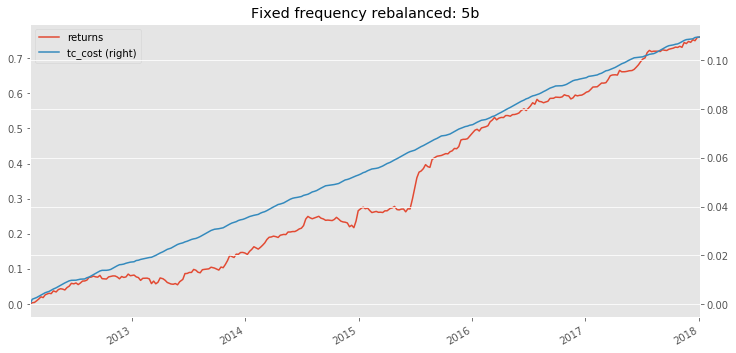

In [6]:
"""
Predicting and re-balance phase
"""

factor_groups = const_model_factor_data.groupby('trade_date')

for weight_gap in weight_gaps:
    print("start {0} weight gap simulation ...".format(weight_gap))

    rets = []
    turn_overs = []
    leverags = []
    previous_pos = pd.DataFrame()

    index_dates = []

    for i, value in enumerate(factor_groups):
        date = value[0]
        data = value[1]
        ref_date = date.strftime('%Y-%m-%d')

        total_data = data.fillna(data[total_features_keys].median())
        alpha_logger.info('{0}: {1}'.format(date, len(total_data)))
        risk_exp = total_data[neutralize_risk].values.astype(float)
        industry = total_data.industry_code.values
        benchmark_w = total_data.weight.values

        constraint_exp = total_data[constraint_risk].values
        risk_exp_expand = np.concatenate((constraint_exp, np.ones((len(risk_exp), 1))), axis=1).astype(float)

        risk_names = constraint_risk + ['total']
        risk_target = risk_exp_expand.T @ benchmark_w

        lbound = np.maximum(0., benchmark_w - weight_gap)  # np.zeros(len(total_data))
        ubound = weight_gap + benchmark_w

        is_in_benchmark = (benchmark_w > 0.).astype(float)

        risk_exp_expand = np.concatenate((risk_exp_expand, is_in_benchmark.reshape((-1, 1))), axis=1).astype(float)
        risk_names.append('benchmark_total')

        constraint = Constraints(risk_exp_expand, risk_names)

        for i, name in enumerate(risk_names):
            if name == 'total':
                constraint.set_constraints(name,
                                           lower_bound=risk_target[i],
                                           upper_bound=risk_target[i])
            elif name == 'SIZE':
                base_target = abs(risk_target[i])
                constraint.set_constraints(name,
                                           lower_bound=risk_target[i] + base_target * size_risk_lower,
                                           upper_bound=risk_target[i] + base_target * size_risk_upper)
            elif name == 'benchmark_total':
                base_target = benchmark_w.sum()
                constraint.set_constraints(name,
                                           lower_bound=benchmark_total_lower * base_target,
                                           upper_bound=benchmark_total_upper * base_target)
            else:
                constraint.set_constraints(name,
                                           lower_bound=risk_target[i] * industry_lower,
                                           upper_bound=risk_target[i] * industry_upper)
        
        factor_values = factor_processing(total_data[const_features_keys].values,
                                          pre_process=[winsorize_normal, standardize],
                                          risk_factors=risk_exp,
                                          post_process=[winsorize_normal, standardize])

        # const linear model
        er1 = const_model.predict(factor_values)

        # linear regression model
        models = models_series[models_series.index <= date]
        if models.empty:
            continue

        index_dates.append(date)
        model = models[-1]

        # x = predict_x[date]
        x = factor_processing(total_data[linear_model_features_keys].values,
                              pre_process=[winsorize_normal, standardize],
                              risk_factors=risk_exp,
                              post_process=[winsorize_normal, standardize])
        er2 = model.predict(x)

        # combine model
        er1_table = pd.DataFrame({'er1': er1, 'code': total_data.code.values})
        er2_table = pd.DataFrame({'er2': er2, 'code': total_data.code.values})
        er_table = pd.merge(er1_table, er2_table, on=['code'], how='left').fillna(0)

        er1 = er_table.er1.values
        er2 = er_table.er2.values
        
        if er2.std() > 0:
            print('using alpha model')
        
        er = model1_weight * er1 +  model2_weight * er2

        codes = total_data['code'].values

        if previous_pos.empty:
            current_position = None
            turn_over_target = None
        else:
            previous_pos.set_index('code', inplace=True)
            remained_pos = previous_pos.loc[codes]

            remained_pos.fillna(0., inplace=True)
            turn_over_target = turn_over_target_base
            current_position = remained_pos.weight.values

        try:
            target_pos, _ = er_portfolio_analysis(er,
                                                  industry,
                                                  None,
                                                  constraint,
                                                  False,
                                                  benchmark_w,
                                                  method=method,
                                                  use_rank=use_rank,
                                                  turn_over_target=turn_over_target,
                                                  current_position=current_position,
                                                  lbound=lbound,
                                                  ubound=ubound)
        except ValueError:
            alpha_logger.info('{0} full re-balance'.format(date))
            target_pos, _ = er_portfolio_analysis(er,
                                                  industry,
                                                  None,
                                                  constraint,
                                                  False,
                                                  benchmark_w,
                                                  method=method,
                                                  use_rank=use_rank,
                                                  lbound=lbound,
                                                  ubound=ubound)

        target_pos['code'] = total_data['code'].values

        turn_over, executed_pos = executor.execute(target_pos=target_pos)

        executed_codes = executed_pos.code.tolist()
        dx_returns = engine.fetch_dx_return(date, executed_codes, horizon=horizon, offset=1)

        result = pd.merge(executed_pos, total_data[['code', 'weight']], on=['code'], how='inner')
        result = pd.merge(result, dx_returns, on=['code'])

        leverage = result.weight_x.abs().sum()

        ret = result.weight_x.values @ (np.exp(result.dx.values) - 1.)
        rets.append(np.log(1. + ret))
        executor.set_current(executed_pos)
        turn_overs.append(turn_over)
        leverags.append(leverage)

        previous_pos = executed_pos
        alpha_logger.info('{0} is finished'.format(date))

    ret_df = pd.DataFrame({'returns': rets, 'turn_over': turn_overs, 'leverage': leverage}, index=index_dates)

    # index return
    index_return = engine.fetch_dx_return_index_range(benchmark_code, start_date, end_date, horizon=horizon,
                                                      offset=1).set_index('trade_date')
    ret_df['index'] = index_return['dx']

    ret_df.loc[advanceDateByCalendar('china.sse', ref_dates[-1], frequency)] = 0.
    ret_df = ret_df.shift(1)
    ret_df.iloc[0] = 0.
    ret_df['tc_cost'] = ret_df.turn_over * 0.002
    ret_df['returns'] = ret_df['leverage'] * (ret_df['returns'] - ret_df['index'])

    ret_df[['returns', 'tc_cost']].cumsum().plot(figsize=(12, 6),
                                                 title='Fixed frequency rebalanced: {0}'.format(frequency),
                                                 secondary_y='tc_cost')

    ret_df['ret_after_tc'] = ret_df['returns'] - ret_df['tc_cost']
    ret_df.to_csv('d:/hs300.csv')
    

#     sharp_calc = MovingSharp(49)
#     drawdown_calc = MovingMaxDrawdown(49)
#     max_drawdown_calc = MovingMaxDrawdown(len(ret_df))

#     res_df = pd.DataFrame(columns=['daily_return', 'cum_ret', 'sharp', 'drawdown', 'max_drawn', 'leverage'])

#     total_returns = 0.

#     for i, ret in enumerate(ret_df['ret_after_tc']):
#         date = ret_df.index[i]
#         total_returns += ret
#         sharp_calc.push({'ret': ret, 'riskFree': 0.})
#         drawdown_calc.push({'ret': ret})
#         max_drawdown_calc.push({'ret': ret})

#         res_df.loc[date, 'daily_return'] = ret
#         res_df.loc[date, 'cum_ret'] = total_returns
#         res_df.loc[date, 'drawdown'] = drawdown_calc.result()[0]
#         res_df.loc[date, 'max_drawn'] = max_drawdown_calc.result()[0]
#         res_df.loc[date, 'leverage'] = ret_df.loc[date, 'leverage']

#         if i < 10:
#             res_df.loc[date, 'sharp'] = 0.
#         else:
#             res_df.loc[date, 'sharp'] = sharp_calc.result() * np.sqrt(49)

#     res_df.to_csv('hs300_{0}.csv'.format(int(weight_gap * 100)))

## combine
-------------

In [50]:
from pandas import ExcelWriter
writer = ExcelWriter('d:/多因子500+300合并.xlsx')

df1 = pd.read_csv('d:/hs300.csv', index_col=0)
df2 = pd.read_csv('d:/zz500.csv', index_col=0)

In [51]:
weights_secnario = {
    '3-1': (3., 1.),
    '2-1': (2., 1.),
    '1-1': (1., 1.),
}

In [52]:
for key, weights in weights_secnario.items():
    weight300, weight500 = weights
    ret_series = (weight300* df1['ret_after_tc'] + weight500 * df2['ret_after_tc']) /  (weight300 + weight500)

    sharp_calc = MovingSharp(49)
    drawdown_calc = MovingMaxDrawdown(49)
    max_drawdown_calc = MovingMaxDrawdown(len(ret_df))

    res_df = pd.DataFrame(columns=['daily_return', 'cum_ret', 'sharp', 'drawdown', 'max_drawn'])

    total_returns = 0.

    for i, ret in enumerate(ret_series):
        date = ret_series.index[i]
        sharp_calc.push({'ret': ret, 'riskFree': 0.})
        drawdown_calc.push({'ret': ret})
        max_drawdown_calc.push({'ret': ret})
        total_returns += ret
        res_df.loc[date, 'daily_return'] = ret
        res_df.loc[date, 'cum_ret'] = total_returns
        res_df.loc[date, 'drawdown'] = drawdown_calc.result()[0]
        res_df.loc[date, 'max_drawn'] = max_drawdown_calc.result()[0]

        if i < 10:
            res_df.loc[date, 'sharp'] = 0.
        else:
            res_df.loc[date, 'sharp'] = sharp_calc.result() * np.sqrt(49)
            
        res_df.to_excel(writer, key)

In [53]:
writer.save()